# Explainer Model Performance Analysis

This notebook analyzes the performance of different explainer models in generating explanations for SAE latent features. We compare models across multiple metrics including accuracy, F1 scores, token usage, and execution time.

## Recent Updates
- **Updated to 400 latents**: Changed from 100 to 400 latents to match the experiment configuration
- **Fixed directory pattern matching**: Now handles both old (with suffix) and new (without suffix) directory naming conventions
- **Simplified loading process**: Now uses functions from `result_analysis.py` to reduce redundancy
- **Enhanced model support**: Updated model name mapping for better display names and added GPT-OSS-20B
- **Bootstrapped confidence intervals**: Error bars now use 95% CI via bootstrapping (2000 resamples) instead of standard deviation
- **Progress bars**: Added TQDM progress bars for bootstrap calculations to show progress
- **Better variable naming**: Renamed `accuracy_df` to `performance_df` for clarity

## Analysis Overview

- **Accuracy Distribution**: Density plots showing accuracy distribution for each model
- **Mean Performance**: Bar charts comparing mean accuracy across models
- **Token Usage**: Analysis of computational efficiency and resource consumption
- **Performance Summary**: Comprehensive comparison tables

## 1. Setup and Configuration

Import required libraries, define model name mapping for prettier display names, and set up output directories.

In [1]:
import sys
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from scipy import stats
from tqdm.auto import tqdm

# Add the parent directory to the path to import delphi modules
sys.path.append(str(Path.cwd().parent))

from delphi.log.result_analysis import (
    import_plotly,
    load_data,
    get_agg_metrics,
    add_latent_f1,
    compute_confusion,
    compute_classification_metrics,
    frequency_weighted_f1
)

# Import plotly for plotting
px = import_plotly()

# Toggle for whether to run expensive bootstrap resampling
ENABLE_BOOTSTRAP = True  # Set to True to run bootstrap resampling (slow)
BOOTSTRAP_SAMPLES = 4000  # Number of bootstrap resamples when enabled
# Confidence level for CI calculations (e.g. 0.95 for 95% CI). Make configurable.
CONFIDENCE_LEVEL = 0.95

# Configuration - Model prefix for experiment naming
MODEL_PREFIX = "pythiaST"  # Change this to match your base model (e.g., "pythia", "gemma", etc.)
LATENTS_COUNT = 400  # Number of latents used in experiments
COMPARE_THINKING_MODES = False  # Set to True to compare both thinking and non-thinking modes (Currently broken if set to True)

# Define model name mapping for prettier display - updated to match actual directory names
MODEL_NAME_MAPPING = {
    "gemma_3_4b_it_quantized_w4a16": "Gemma3-4B",
    "Qwen3_4B_quantized_w4a16": "Qwen3-4B", 
    "gemma_3_12b_it_quantized_w4a16": "Gemma3-12B",
    "gemma_3_27b_it_quantized_w4a16": "Gemma3-27B",
    "Qwen3_14B_quantized_w4a16": "Qwen3-14B",
    "Qwen3_32B_quantized_w4a16": "Qwen3-32B",
    "Qwen3_235B_A22B_GPTQ_Int4": "Qwen3-235B",
    "Llama_3_3_70B_Instruct_quantized_w4a16": "Llama3.3-70B",
    "Llama_3_1_70B_Instruct_NVFP4": "Llama3.1-70B",
    "Llama_4_Scout_17B_16E_Instruct_quantized_w4a16": "Llama4-Scout",
    "Llama_4_Maverick_17B_128E_Instruct_quantized_w4a16": "Llama4-Maverick",
    "llama_8b_explainer": "Llama3-8B (Transluce)",
    "Meta_Llama_3_1_8B_Instruct_GPTQ_INT4": "Llama3-8B",
    "gpt_oss_20b": "GPT-OSS-20B"
}

def load_model_results(results_dir: Path, model_mapping: dict, model_prefix: str, latents_count: int, compare_modes: bool = False):
    """Load results and statistics for all explainer models using functions from result_analysis.py."""
    model_results = {}
    model_stats = {}

    # Base directory for experiments with this latent count
    experiments_base = results_dir / model_prefix / f"{latents_count}latents"

    if not experiments_base.exists():
        print(f"Warning: Experiments directory not found: {experiments_base}")
        return model_results, model_stats

    # Pattern for experiment directories (exclude thinking mode and hide directories)
    # Handle both naming conventions: with and without latents suffix
    pattern_with_suffix = f"{model_prefix}_*_{latents_count}latents"
    pattern_without_suffix = f"{model_prefix}_*"
    
    all_exp_dirs = []
    # First try directories with latents suffix (older format)
    for exp_dir in experiments_base.glob(pattern_with_suffix):
        if not ("thinking" in exp_dir.name or "hide" in exp_dir.name):
            all_exp_dirs.append(exp_dir)
    
    # Then try directories without latents suffix (newer format)
    if not all_exp_dirs:
        for exp_dir in experiments_base.glob(pattern_without_suffix):
            if (not ("thinking" in exp_dir.name or "hide" in exp_dir.name) and 
                exp_dir.name != "cache"):  # Exclude cache directory
                all_exp_dirs.append(exp_dir)

    for exp_dir in all_exp_dirs:
        # Skip directories with "thinking" or "hide" in the name
        if "thinking" in exp_dir.name or "hide" in exp_dir.name:
            continue

        # Extract model name from directory: handle both naming conventions
        dir_name = exp_dir.name
        if dir_name.endswith(f"_{latents_count}latents"):
            # Old format: pythiaST_model_400latents
            model_key = dir_name.replace(f"{model_prefix}_", "").replace(f"_{latents_count}latents", "")
        else:
            # New format: pythiaST_model
            model_key = dir_name.replace(f"{model_prefix}_", "")
        
        base_display_name = model_mapping.get(model_key, model_key)
        display_name = base_display_name

        scores_path = exp_dir / "scores"
        if scores_path.exists():
            # Load scoring results using functions from result_analysis.py
            try:
                # All experiments now use the shared cache
                cache_dir_name = "cache"
                latents_path = experiments_base.parent / cache_dir_name / "latents"
                if not latents_path.exists():
                    latents_path = exp_dir / "latents"  # Fallback to local latents

                if latents_path.exists():
                    # Extract module names from the actual files
                    sample_score_dir = next(scores_path.iterdir())
                    sample_files = list(sample_score_dir.glob("*.txt"))
                    if sample_files:
                        # Extract module name from filename pattern (e.g., "layers.32_latent0.txt" -> "layers.32")
                        sample_filename = sample_files[0].stem
                        module_name = sample_filename.split('_latent')[0]
                        modules = [module_name]
                    else:
                        print(f"No score files found in {sample_score_dir}")
                        continue

                    # Use load_data from result_analysis.py
                    latent_df, counts = load_data(scores_path, latents_path, modules)

                    if latent_df.empty:
                        print(f"No data found for {display_name}")
                        continue

                    # Use add_latent_f1 and get_agg_metrics from result_analysis.py
                    latent_df = add_latent_f1(latent_df)
                    processed_df = get_agg_metrics(latent_df, counts)

                    model_results[display_name] = {
                        'latent_df': latent_df,
                        'processed_df': processed_df,
                        'counts': counts
                    }
                else:
                    print(f"Latents path not found for {display_name}")

            except Exception as e:
                print(f"Error loading results for {model_key}: {e}")
                continue

        # Load explainer statistics
        stats_file = exp_dir / "explainer_stats.json"
        if stats_file.exists():
            try:
                with open(stats_file, 'r') as f:
                    stats = json.load(f)
                    model_stats[display_name] = stats
            except Exception as e:
                print(f"Error loading stats for {model_key}: {e}")
                model_stats[display_name] = None
        else:
            model_stats[display_name] = None

    return model_results, model_stats

# Set up directories
results_dir = Path.cwd().parent / "results"
visualizations_dir = results_dir / "visualizations"
visualizations_dir.mkdir(exist_ok=True, parents=True)

print(f"Model prefix: {MODEL_PREFIX}")
print(f"Latents count: {LATENTS_COUNT}")
print(f"Compare thinking modes: {COMPARE_THINKING_MODES}")
print(f"Results directory: {results_dir}")
print(f"Visualizations output: {visualizations_dir}")

# Check if the experiments directory exists
experiments_dir = results_dir / MODEL_PREFIX / f"{LATENTS_COUNT}latents"
print(f"Experiments directory: {experiments_dir}")

if experiments_dir.exists():
    print(f"Available experiments ({LATENTS_COUNT} latents):")
    # Handle both naming conventions: with and without latents suffix
    pattern_with_suffix = f"{MODEL_PREFIX}_*_{LATENTS_COUNT}latents"
    pattern_without_suffix = f"{MODEL_PREFIX}_*"
    
    all_exp_dirs = []
    # First try directories with latents suffix (older format)
    for exp_dir in sorted(experiments_dir.glob(pattern_with_suffix)):
        if not ("thinking" in exp_dir.name or "hide" in exp_dir.name):
            all_exp_dirs.append(exp_dir)
    
    # Then try directories without latents suffix (newer format)
    if not all_exp_dirs:
        for exp_dir in sorted(experiments_dir.glob(pattern_without_suffix)):
            if (not ("thinking" in exp_dir.name or "hide" in exp_dir.name) and 
                exp_dir.name != "cache"):  # Exclude cache directory
                all_exp_dirs.append(exp_dir)
    
    for exp_dir in all_exp_dirs:
        print(f"  - {exp_dir.name}")
else:
    print(f"Warning: Experiments directory not found: {experiments_dir}")
    print("Make sure experiments have been run with the specified latent count.")

Model prefix: pythiaST
Latents count: 400
Compare thinking modes: False
Results directory: /home/jeremias/projects/delphi-explanations/results
Visualizations output: /home/jeremias/projects/delphi-explanations/results/visualizations
Experiments directory: /home/jeremias/projects/delphi-explanations/results/pythiaST/400latents
Available experiments (400 latents):
  - pythiaST_Llama_3_3_70B_Instruct_quantized_w4a16
  - pythiaST_Llama_4_Scout_17B_16E_Instruct_quantized_w4a16
  - pythiaST_Meta_Llama_3_1_8B_Instruct_GPTQ_INT4
  - pythiaST_Qwen3_14B_quantized_w4a16
  - pythiaST_Qwen3_32B_quantized_w4a16
  - pythiaST_Qwen3_4B_quantized_w4a16
  - pythiaST_gemma_3_12b_it_quantized_w4a16
  - pythiaST_gemma_3_27b_it_quantized_w4a16
  - pythiaST_gemma_3_4b_it_quantized_w4a16
  - pythiaST_llama_8b_explainer


## 2. Load Model Results

Load explanation comparison results from all models and extract performance metrics.

In [2]:
# Load all model results and statistics
print("Loading model results...")
model_results, model_stats = load_model_results(results_dir, MODEL_NAME_MAPPING, MODEL_PREFIX, LATENTS_COUNT, COMPARE_THINKING_MODES)

print(f"\nLoaded results for {len(model_results)} models:")
for model_name in model_results.keys():
    print(f"  - {model_name}")

print(f"\nToken usage statistics available for {len([k for k, v in model_stats.items() if v is not None])} models:")
for model_name, stats in model_stats.items():
    if stats:
        print(f"  - {model_name}: {list(stats.keys())}")
    else:
        print(f"  - {model_name}: No stats available")

# Display sample metrics for the first model
if model_results:
    sample_model = list(model_results.keys())[0]
    sample_data = model_results[sample_model]['processed_df']
    print(f"\nSample metrics from {sample_model}:")
    print(sample_data[['score_type', 'accuracy', 'f1_score', 'precision', 'recall']].round(3))

Loading model results...


/home/jeremias/projects/delphi-explanations/delphi/log/result_analysis.py:444: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/jeremias/projects/delphi-explanations/delphi/log/result_analysis.py:444: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/jeremias/projects/delphi-explanations/delphi/log/result_analysis.py:444: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is d


Loaded results for 10 models:
  - Qwen3-4B
  - Gemma3-4B
  - Gemma3-12B
  - Gemma3-27B
  - Qwen3-14B
  - Qwen3-32B
  - Llama3.3-70B
  - Llama3-8B
  - Llama4-Scout
  - Llama3-8B (Transluce)

Token usage statistics available for 10 models:
  - Qwen3-4B: ['DefaultExplainer']
  - Gemma3-4B: ['DefaultExplainer']
  - Gemma3-12B: ['DefaultExplainer']
  - Gemma3-27B: ['DefaultExplainer']
  - Qwen3-14B: ['DefaultExplainer']
  - Qwen3-32B: ['DefaultExplainer']
  - Llama3.3-70B: ['DefaultExplainer']
  - Llama3-8B: ['DefaultExplainer']
  - Llama4-Scout: ['DefaultExplainer']
  - Llama3-8B (Transluce): ['DefaultExplainer']

Sample metrics from Qwen3-4B:
  score_type  accuracy  f1_score  precision  recall
0  detection     0.757     0.755      0.763   0.747
1       fuzz     0.818     0.827      0.787   0.871


## 3. Generate Mean F1 Score Bar Charts

Create bar charts displaying mean F1 scores with **bootstrapped 95% confidence intervals** (2000 resamples) for each model and score type. This provides more robust uncertainty estimates compared to standard deviation.

In [3]:
# Generate inline bar charts for frequency-weighted F1 scores with optional bootstrapped CI error bars and save to files
print("Preparing frequency-weighted F1 score bar charts (bootstrapping={})...".format(ENABLE_BOOTSTRAP))

from tqdm.auto import tqdm

# Helper: per-module F1s (unchanged)
def compute_per_module_f1s(score_subset, counts):
    """Return list of per-module frequency-weighted F1 values computed from the given score_subset (no resampling).
    Each module contributes a single weighted F1 computed from its latents in score_subset."""
    rows = []
    for (module, latent_idx), grp in score_subset.groupby(["module", "latent_idx"]):
        if module in counts and latent_idx < len(counts[module]):
            f1 = compute_classification_metrics(compute_confusion(grp))["f1_score"]
            fire = counts[module][latent_idx].item()
            rows.append({"module": module, "latent_idx": latent_idx, "f1_score": f1, "firing_count": fire})
    if not rows:
        return []
    df = pd.DataFrame(rows)
    per_module_vals = []
    for module in df['module'].unique():
        mdf = df[df['module'] == module]
        firing_weights = counts[module][mdf['latent_idx']].float()
        total_weight = firing_weights.sum()
        if total_weight > 0:
            f1_tensor = torch.as_tensor(mdf['f1_score'].values, dtype=torch.float32)
            module_f1 = (f1_tensor * firing_weights).sum() / firing_weights.sum()
            per_module_vals.append(module_f1.item())
    return per_module_vals

# Helper: weighted percentile (unchanged)
def weighted_percentile(values, weights, percentiles):
    """Compute weighted percentiles for 1D arrays of values and corresponding non-negative weights."""
    if len(values) == 0:
        return [np.nan for _ in np.atleast_1d(percentiles)]
    vals = np.asarray(values, dtype=float)
    w = np.asarray(weights, dtype=float)
    if w.sum() == 0:
        # Fall back to unweighted percentiles
        return np.percentile(vals, percentiles)
    # sort by value
    order = np.argsort(vals)
    vals = vals[order]
    w = w[order]
    cumsum = np.cumsum(w)
    total = cumsum[-1]
    # cumulative fraction positions of each value
    cumfrac = (cumsum - 0.5 * w) / total
    out = []
    for p in np.atleast_1d(percentiles) / 100.0:
        # find the first index where cumfrac >= p
        idx = np.searchsorted(cumfrac, p, side='left')
        if idx >= len(vals):
            out.append(vals[-1])
        else:
            out.append(vals[idx])
    return out if len(out) > 1 else out[0]

# Helper: compute CI errors from samples
def compute_ci_from_samples(samples, freq_weighted_f1, confidence):
    if not samples:
        return 0.0, 0.0
    lower_pct = (1.0 - confidence) / 2.0 * 100.0
    upper_pct = (1.0 + confidence) / 2.0 * 100.0
    lower_ci, upper_ci = np.percentile(samples, [lower_pct, upper_pct])
    return float(freq_weighted_f1 - lower_ci), float(upper_ci - freq_weighted_f1)

# Optimized bootstrap: avoid DataFrame creation in loop using multinomial + np.bincount
def run_bootstrap_single_thread_optimized(score_subset, counts, n_boot, confidence):
    """Optimized bootstrap using multinomial sampling on precomputed latents.

    Strategy:
    - Precompute per-latent F1 and firing weights and module ids
    - For each bootstrap iteration generate multinomial counts over latents
    - Use np.bincount to aggregate weighted sums per module efficiently
    """
    # Pre-compute grouped stats once
    grouped = list(score_subset.groupby(["module", "latent_idx"]))

    latent_f1s = []
    latent_weights = []
    module_names = []

    for (module, latent_idx), grp in grouped:
        if module in counts and latent_idx < len(counts[module]):
            f1 = compute_classification_metrics(compute_confusion(grp))["f1_score"]
            fire_count = counts[module][latent_idx].item()
            latent_f1s.append(float(f1))
            latent_weights.append(float(fire_count))
            module_names.append(module)

    if not latent_f1s:
        return []

    latent_f1s = np.asarray(latent_f1s, dtype=np.float64)
    latent_weights = np.asarray(latent_weights, dtype=np.float64)
    unique_modules, module_ids = np.unique(module_names, return_inverse=True)
    num_modules = len(unique_modules)
    num_latents = len(latent_f1s)

    samples = []

    # Generate multinomial samples: draw counts across latents
    # Use equal probability across latents (resampling latents uniformly)
    # sum of each row will be num_latents (you can change this to len(score_subset) if desired)
    try:
        resampled_counts = np.random.multinomial(num_latents, [1.0 / num_latents] * num_latents, size=n_boot)
    except Exception:
        # Fallback: generate per-iteration to avoid large allocation
        resampled_counts = None

    for i in tqdm(range(n_boot), desc=f"Fast Bootstrapping ({n_boot})", leave=False):
        if resampled_counts is None:
            boot_counts = np.random.multinomial(num_latents, [1.0 / num_latents] * num_latents)
        else:
            boot_counts = resampled_counts[i]

        # Numerator: sum of f1 * latent_weight * boot_count per module
        numerator = np.bincount(module_ids, weights=latent_f1s * latent_weights * boot_counts, minlength=num_modules)
        # Denominator: sum of latent_weight * boot_count per module
        denominator = np.bincount(module_ids, weights=latent_weights * boot_counts, minlength=num_modules)

        # per-module f1 (avoid division by zero)
        per_module_f1s = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
        samples.append(float(per_module_f1s.mean()))

    return samples

# Main: compute_error_bars simplified to use the optimized bootstrap
def compute_error_bars(model_results, score_type, enable_bootstrap: bool = ENABLE_BOOTSTRAP, n_boot: int = BOOTSTRAP_SAMPLES, confidence: float = CONFIDENCE_LEVEL):
    """Compute frequency-weighted F1 and CI errors for every model for a given score_type.

    Returns a DataFrame with columns: model, frequency_weighted_f1, ci_lower_error, ci_upper_error
    """
    rows = []
    for model_name, data in model_results.items():
        processed_df = data['processed_df']
        score_row = processed_df[processed_df['score_type'] == score_type]
        if len(score_row) == 0:
            continue
        freq_weighted_f1 = score_row['weighted_f1'].iloc[0] if 'weighted_f1' in score_row.columns else None
        latent_df = data['latent_df']
        counts = data['counts']
        score_subset = latent_df[latent_df['score_type'] == score_type]
        if len(score_subset) == 0 or counts is None or freq_weighted_f1 is None:
            rows.append({'model': model_name, 'frequency_weighted_f1': freq_weighted_f1, 'ci_lower_error': 0.0, 'ci_upper_error': 0.0})
            continue

        if enable_bootstrap:
            # Use optimized multinomial-based bootstrap
            samples = run_bootstrap_single_thread_optimized(score_subset, counts, n_boot, confidence)
            ci_lower_error, ci_upper_error = compute_ci_from_samples(samples, freq_weighted_f1, confidence)
        else:
            # Fast path: compute weighted percentiles across per-latent F1s using firing_count as weight
            vals = []
            wts = []
            for (module, latent_idx), grp in score_subset.groupby(["module", "latent_idx"]):
                if module in counts and latent_idx < len(counts[module]):
                    f1 = compute_classification_metrics(compute_confusion(grp))["f1_score"]
                    fire = counts[module][latent_idx].item()
                    vals.append(float(f1))
                    wts.append(float(fire))
            if len(vals) == 0:
                ci_lower_error = 0.0
                ci_upper_error = 0.0
            else:
                lower_pct = (1.0 - confidence) / 2.0 * 100.0
                upper_pct = (1.0 + confidence) / 2.0 * 100.0
                lower_ci, upper_ci = weighted_percentile(np.array(vals), np.array(wts), [lower_pct, upper_pct])
                lower_ci = float(lower_ci)
                upper_ci = float(upper_ci)
                ci_lower_error = float(freq_weighted_f1 - lower_ci)
                ci_upper_error = float(upper_ci - freq_weighted_f1)

        rows.append({'model': model_name, 'frequency_weighted_f1': float(freq_weighted_f1), 'ci_lower_error': ci_lower_error, 'ci_upper_error': ci_upper_error})

    df = pd.DataFrame(rows)
    return df

# Example: compute error bars for each score_type and save/use for plotting
all_score_types = set()
for data in model_results.values():
    all_score_types.update(list(data['processed_df']['score_type'].unique()))
all_score_types = sorted(list(all_score_types))

# Precompute error bar tables for reuse in other plots
error_bar_tables = {}
for st in all_score_types:
    print(f"Computing error bars for score type: {st} (bootstrap={ENABLE_BOOTSTRAP})")
    error_bar_tables[st] = compute_error_bars(model_results, st, enable_bootstrap=ENABLE_BOOTSTRAP, n_boot=BOOTSTRAP_SAMPLES, confidence=CONFIDENCE_LEVEL)

# helper to display nicer score type names
def score_display_name(st):
    return 'Fuzzing' if str(st).lower() == 'fuzz' else str(st).title()

# Now create bar charts using precomputed error bars
for score_type, error_df in error_bar_tables.items():
    if error_df.empty:
        continue
    error_df = error_df.sort_values('frequency_weighted_f1', ascending=False)
    fig = px.bar(
        error_df,
        x='model',
        y='frequency_weighted_f1',
        title=f'Frequency-Weighted F1 Score by Model - {score_display_name(score_type)} ({int(CONFIDENCE_LEVEL*100)}% CI)',
        text='frequency_weighted_f1'
    )
    fig.update_traces(
        error_y=dict(
            type='data',
            symmetric=False,
            array=error_df['ci_upper_error'],
            arrayminus=error_df['ci_lower_error']
        )
    )
    fig.update_layout(
        yaxis_range=[0, 1],
        xaxis_title="Model",
        yaxis_title=f"Frequency-Weighted F1 Score ({int(CONFIDENCE_LEVEL*100)}% CI)",
        xaxis={'tickangle': 45},
        height=500
    )
    fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
    fig.show()
    output_file_pdf = visualizations_dir / f"freq_weighted_f1_bar_{score_type}.pdf"
    output_file_png = visualizations_dir / f"freq_weighted_f1_bar_{score_type}.png"
    fig.write_image(str(output_file_pdf))
    fig.write_image(str(output_file_png))
    print(f"Saved Frequency-Weighted F1 bar chart: {output_file_pdf}")

print("\nBar charts saved to", visualizations_dir)

Preparing frequency-weighted F1 score bar charts (bootstrapping=True)...
Computing error bars for score type: detection (bootstrap=True)


Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Computing error bars for score type: fuzz (bootstrap=True)


Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

Fast Bootstrapping (4000):   0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_516767/3945258560.py:226: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




Saved Frequency-Weighted F1 bar chart: /home/jeremias/projects/delphi-explanations/results/visualizations/freq_weighted_f1_bar_detection.pdf


/tmp/ipykernel_516767/3945258560.py:227: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




/tmp/ipykernel_516767/3945258560.py:226: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).


/tmp/ipykernel_516767/3945258560.py:227: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




Saved Frequency-Weighted F1 bar chart: /home/jeremias/projects/delphi-explanations/results/visualizations/freq_weighted_f1_bar_fuzz.pdf

Bar charts saved to /home/jeremias/projects/delphi-explanations/results/visualizations


## 5. Performance Summary

Display a summary table of F1 scores for each model and score type, including mean and standard deviation.

In [4]:
# Create comprehensive performance summary using data from get_agg_metrics
print("Creating comprehensive performance summary...")

# Create frequency-weighted F1 score summary using processed data
summary_rows = []
for model_name, model_data in model_results.items():
    processed_df = model_data['processed_df']
    # Use the frequency-weighted F1 from the processed data (averaged across score types)
    freq_weighted_f1 = processed_df['weighted_f1'].mean() if 'weighted_f1' in processed_df.columns else None
    summary_rows.append({
        'model': model_name,
        'frequency_weighted_f1': freq_weighted_f1,
        'accuracy': processed_df['accuracy'].mean(),
        'precision': processed_df['precision'].mean(),
        'recall': processed_df['recall'].mean()
    })
summary_df = pd.DataFrame(summary_rows).set_index('model').round(3)

print("\nModel Performance Summary (Frequency-Weighted F1 Focus):")
print("=" * 60)
print(summary_df.sort_values('frequency_weighted_f1', ascending=False))

# Save summary to CSV
summary_file = visualizations_dir / "model_frequency_weighted_f1_summary.csv"
summary_df.to_csv(summary_file)
print(f"\nSummary saved to: {summary_file}")

# Best performing models by category
print("\nBest Performing Models by Category:")
print("=" * 50)
print(f"Highest Frequency-Weighted F1: {summary_df['frequency_weighted_f1'].idxmax()} ({summary_df['frequency_weighted_f1'].max():.3f})")
print(f"Highest Accuracy: {summary_df['accuracy'].idxmax()} ({summary_df['accuracy'].max():.3f})")
print(f"Highest Precision: {summary_df['precision'].idxmax()} ({summary_df['precision'].max():.3f})")
print(f"Highest Recall: {summary_df['recall'].idxmax()} ({summary_df['recall'].max():.3f})")

print(f"\nAll visualizations and summaries saved to: {visualizations_dir}")
print("\nGenerated files:")
for file in sorted(visualizations_dir.glob("*")):
    print(f"  - {file.name}")

Creating comprehensive performance summary...

Model Performance Summary (Frequency-Weighted F1 Focus):
                       frequency_weighted_f1  accuracy  precision  recall
model                                                                    
Qwen3-32B                              0.719     0.845      0.855   0.831
Gemma3-27B                             0.715     0.833      0.817   0.856
Qwen3-4B                               0.686     0.787      0.775   0.809
Llama4-Scout                           0.674     0.813      0.826   0.793
Llama3.3-70B                           0.651     0.842      0.870   0.806
Gemma3-12B                             0.642     0.788      0.816   0.750
Qwen3-14B                              0.627     0.813      0.877   0.731
Llama3-8B                              0.607     0.775      0.808   0.735
Gemma3-4B                              0.596     0.584      0.567   0.733
Llama3-8B (Transluce)                  0.578     0.807      0.902   0.688

Summary

In [10]:
%matplotlib widget

import json
import numpy as np
from math import isnan
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
from adjustText import adjust_text  # For better label placement
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.widgets import Button as MPLButton

# Optional widget-based Save button (more reliable in notebook frontends)
try:
    import ipywidgets as widgets
    from IPython.display import display
    HAS_IPYWIDGETS = True
except Exception:
    HAS_IPYWIDGETS = False

# Small debug toggle
DEBUG_INTERACTIVE = True

# Set style for prettier plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# --- Data Loading and Prep (same as before) ---
experiments_base = results_dir / MODEL_PREFIX / f"{LATENTS_COUNT}latents"
timing_map = {}
for timing_file in experiments_base.rglob('scoring_timing.json'):
    try:
        with open(timing_file, 'r') as f: meta = json.load(f)
        secs = meta.get('scoring_time_seconds', None)
    except Exception: secs = None
    exp_dir = timing_file.parent; exp_name = exp_dir.name
    if exp_name.endswith(f"_{LATENTS_COUNT}latents"): 
        model_key = exp_name.replace(f"{MODEL_PREFIX}_", "").replace(f"_{LATENTS_COUNT}latents", "")
    else: 
        model_key = exp_name.replace(f"{MODEL_PREFIX}_", "")
    display_name = MODEL_NAME_MAPPING.get(model_key, model_key)
    timing_map[display_name] = secs

for m in model_results.keys():
    if m not in timing_map: timing_map[m] = float('nan')

# Enhanced color palette with gradients
family_colors = {
    'Gemma': '#2E7D32',  # Rich green
    'Qwen': '#7B1FA2',   # Deep purple
    'Llama': '#1565C0'   # Strong blue
}

# Lighter versions for fills
family_colors_light = {
    'Gemma': '#81C784',
    'Qwen': '#BA68C8',
    'Llama': '#64B5F6'
}

def detect_family(name: str):
    n = name.lower()
    if 'gemma' in n: return 'Gemma'
    if 'qwen' in n: return 'Qwen'
    if 'llama' in n: return 'Llama'
    return 'Other'

def identify_pareto_frontier(df):
    df_sorted = df.sort_values(by='time_minutes', ascending=True)
    pareto_points = []
    max_perf_so_far = -np.inf
    for _, row in df_sorted.iterrows():
        if row['perf'] > max_perf_so_far:
            pareto_points.append(row)
            max_perf_so_far = row['perf']
    return pd.DataFrame(pareto_points)

def smart_label_placement(ax, x, y, labels, colors=None, offset_factor=0.02):
    """Smart placement of labels to avoid overlaps; optional colors list to color text."""
    texts = []
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min if (y_max - y_min) != 0 else 1.0

    for i, (xi, yi, label) in enumerate(zip(x, y, labels)):
        # Initial offset
        offset = y_range * offset_factor
        color = None
        if colors is not None:
            try:
                color = colors[i]
            except Exception:
                color = None

        text_kwargs = dict(ha='center', va='bottom', fontsize=9, fontweight='medium')
        if color:
            text_kwargs['color'] = color

        # Draw label with subtle white bbox to keep readability; edge uses color if available
        edge_color = color if color is not None else 'gray'
        bbox_kwargs = dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor=edge_color, alpha=0.85)

        t = ax.text(xi, yi + offset, label, bbox=bbox_kwargs, **text_kwargs)
        t.set_picker(6)  # Ensure picker is set for all text objects
        texts.append(t)
        if DEBUG_INTERACTIVE:
            print(f"Created label '{label}' at ({xi}, {yi + offset}), picker={t.get_picker()}")

    # Try to use adjust_text if available
    try:
        adjust_text(texts, x, y, 
                   arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.5),
                   expand_points=(1.2, 1.4))
    except Exception:
        # Fallback to manual adjustment if adjust_text not available
        pass

    return texts

class DraggableText:
    """Enable click-and-drag for a list of matplotlib Text artists."""
    def __init__(self, texts, fig):
        self.texts = texts
        self.fig = fig
        self.canvas = fig.canvas
        self.selected = None
        self.offset = (0.0, 0.0)
        self.cidpress = self.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidmotion = self.canvas.mpl_connect('motion_notify_event', self.on_motion)
        self.cidrelease = self.canvas.mpl_connect('button_release_event', self.on_release)

    def on_press(self, event):
        if event.inaxes is None:
            return
        for t in self.texts:
            t.set_picker(6)  # Ensure picker is set for all text objects
            try:
                contains, _ = t.contains(event)
            except Exception:
                contains = False
            if contains:
                x, y = t.get_position()
                # store selected and offset in data coords
                self.selected = t
                if event.xdata is None or event.ydata is None:
                    # nothing to do
                    self.selected = None
                    return
                self.offset = (x - event.xdata, y - event.ydata)
                if DEBUG_INTERACTIVE:
                    try:
                        print(f"Picked label '{t.get_text()}' at data pos {(x, y)}; mouse={(event.xdata, event.ydata)}")
                    except Exception:
                        print("Picked a label")
                return

    def on_motion(self, event):
        if self.selected is None or event.inaxes is None:
            return
        if event.xdata is None or event.ydata is None:
            return
        newx = event.xdata + self.offset[0]
        newy = event.ydata + self.offset[1]
        self.selected.set_position((newx, newy))
        self.canvas.draw_idle()
        if DEBUG_INTERACTIVE:
            try:
                print(f"Moved '{self.selected.get_text()}' -> {(newx, newy)}")
            except Exception:
                pass

    def on_release(self, event):
        if DEBUG_INTERACTIVE and self.selected is not None:
            try:
                print(f"Released '{self.selected.get_text()}'")
            except Exception:
                pass
        self.selected = None

SHOW_MOUSE_COORDS = True  # Toggle to show/hide live mouse coordinates

class MouseCoordsDisplay:
    def __init__(self, fig, ax):
        self.fig = fig
        self.ax = ax
        self.text = ax.text(0.01, 0.99, '', transform=ax.transAxes, ha='left', va='top', fontsize=10, color='navy', alpha=0.7, bbox=dict(facecolor='white', alpha=0.6, edgecolor='navy'))
        self.cidmotion = fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
    def on_motion(self, event):
        if event.inaxes == self.ax and event.xdata is not None and event.ydata is not None:
            self.text.set_text(f"x={event.xdata:.2f}, y={event.ydata:.3f}")
        else:
            self.text.set_text('')
        self.fig.canvas.draw_idle()

def plot_pareto(score_type: str, save_on_init: bool = True, show: bool = True):
    """Create the pareto-enhanced plot for `score_type`. Returns (fig, dr, pts_df) where dr is the DraggableText instance (or None).
    The function expects the notebook globals: error_bar_tables, timing_map, visualizations_dir, family_colors, family_colors_light, SHOW_MOUSE_COORDS, DEBUG_INTERACTIVE.
    """
    error_df = error_bar_tables.get(score_type, pd.DataFrame())
    if error_df.empty:
        print(f"No error-bar data for {score_type}, skipping")
        return None, None, None

    rows = []
    for _, row in error_df.iterrows():
        model, perf, t_secs = row['model'], row['frequency_weighted_f1'], timing_map.get(row['model'])
        if t_secs is None or isnan(t_secs) or perf is None or isnan(perf):
            continue
        rows.append({
            'model': model,
            'time_minutes': float(t_secs) / 60.0,
            'perf': float(perf),
            'up': float(row['ci_upper_error']),
            'down': float(row['ci_lower_error']),
            'family': detect_family(model),
        })

    if not rows:
        print(f"No timing-backed points for {score_type}, skipping")
        return None, None, None

    pts_df = pd.DataFrame(rows).sort_values('time_minutes')
    pts_df = pts_df[pts_df['family'].isin(['Gemma', 'Qwen', 'Llama'])]
    if pts_df.empty:
        print(f"No models left for {score_type} after filtering, skipping")
        return None, None, None

    median_time = pts_df['time_minutes'].median()
    outlier_threshold = median_time * 10
    has_outliers = (pts_df['time_minutes'] >= outlier_threshold).any()

    pareto_df = identify_pareto_frontier(pts_df)

    fig = plt.figure(figsize=(14, 8))

    if has_outliers:
        gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.03)
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharey=ax1)
        cluster_df = pts_df[pts_df['time_minutes'] < outlier_threshold]
        outlier_df = pts_df[pts_df['time_minutes'] >= outlier_threshold]
        axes_data = [(ax1, cluster_df), (ax2, outlier_df)]
    else:
        ax = fig.add_subplot(111)
        axes_data = [(ax, pts_df)]

    collected_texts = []

    if SHOW_MOUSE_COORDS:
        for ax_disp, _ in axes_data:
            MouseCoordsDisplay(fig, ax_disp)

    for ax, df_subset in axes_data:
        ax.set_facecolor('#FAFAFA')
        for family in ['Gemma', 'Qwen', 'Llama']:
            fam_df = df_subset[df_subset['family'] == family]
            if fam_df.empty:
                continue
            ecolor_rgba = mcolors.to_rgba(family_colors_light[family], alpha=0.30)
            ax.errorbar(fam_df['time_minutes'], fam_df['perf'],
                       yerr=[fam_df['down'], fam_df['up']],
                       fmt='o', markersize=12,
                       color=family_colors[family],
                       ecolor=ecolor_rgba,
                       markeredgecolor='white', markeredgewidth=2,
                       capsize=3, capthick=1, elinewidth=1.2,
                       alpha=1.0, zorder=5)

        pareto_subset = pareto_df[pareto_df['model'].isin(df_subset['model'])]
        if not pareto_subset.empty:
            ax.plot(pareto_subset['time_minutes'], pareto_subset['perf'],
                   color='gray', linewidth=4, alpha=0.15, zorder=2)
            ax.plot(pareto_subset['time_minutes'], pareto_subset['perf'],
                   color='#333333', linewidth=2.0, linestyle='-',
                   alpha=0.6, zorder=3)
            ax.scatter(pareto_subset['time_minutes'], pareto_subset['perf'],
                      s=140, facecolor='white', edgecolor='#333333',
                      linewidth=2, zorder=10, alpha=1)

        ax.grid(True, which='major', linestyle='-', alpha=0.2, color='gray')
        ax.grid(True, which='minor', linestyle=':', alpha=0.1, color='gray')
        ax.set_xscale('log')

        # Set nice ticks on the log axis when plotting the main axis
        if ax == (ax1 if has_outliers else ax):
            time_values = df_subset['time_minutes'].values
            min_t = float(np.min(time_values)) if len(time_values) else 1.0
            min_t = max(min_t, 1e-6)
            max_t = float(np.max(time_values)) * 1.2
            try:
                min_exp = int(np.floor(np.log2(min_t)))
            except Exception:
                min_exp = int(np.floor(np.log2(max_t))) - 5
            max_exp = int(np.ceil(np.log2(max_t)))
            exps = list(range(min_exp, max_exp + 1))
            nice_ticks = [2 ** e for e in exps]
            ticks = [t for t in nice_ticks if t >= min_t and t <= max_t]
            if ticks:
                ax.set_xticks(ticks)
                ax.set_xticklabels([str(int(t)) for t in ticks])

        labels_to_plot = []
        label_colors = []
        x_positions = []
        y_positions = []
        for _, r in df_subset.iterrows():
            labels_to_plot.append(r['model'])
            fam = r.get('family', None)
            c = family_colors.get(fam, 'black') if fam is not None else 'black'
            label_colors.append(c)
            x_positions.append(r['time_minutes'])
            y_positions.append(r['perf'] + r['up'] + 0.005)

        texts = smart_label_placement(ax, x_positions, y_positions, labels_to_plot, colors=label_colors)
        collected_texts.extend(texts)

    dr = None
    if collected_texts:
        dr = DraggableText(collected_texts, fig)

        def _save_fig_and_notify():
            out_pdf = visualizations_dir / f"pareto_enhanced_{score_type}.pdf"
            out_png = visualizations_dir / f"pareto_enhanced_{score_type}.png"
            try:
                fig.savefig(out_pdf, dpi=300, bbox_inches='tight', facecolor='white')
                fig.savefig(out_png, dpi=300, bbox_inches='tight', facecolor='white')
                print(f"Saved enhanced pareto plot for {score_type}: {out_pdf}")
            except Exception as e:
                print(f"Failed to save figure: {e}")

        if HAS_IPYWIDGETS:
            try:
                btn = widgets.Button(description='Save', layout=widgets.Layout(width='90px'))
                def _on_save_clicked(b):
                    _save_fig_and_notify()
                btn.on_click(_on_save_clicked)
                display(btn)
                print("Interactive mode: drag labels with the mouse; click the displayed 'Save' button to write the adjusted figure to the visualizations directory.")
            except Exception as e:
                print(f"ipywidgets Save button failed to initialize: {e}. Falling back to in-figure Save button.")
                btn_ax = fig.add_axes([0.88, 0.01, 0.1, 0.04])
                mpl_btn = MPLButton(btn_ax, 'Save', color='lightgoldenrodyellow', hovercolor='0.975')
                def _on_mpl_save(event):
                    _save_fig_and_notify()
                mpl_btn.on_clicked(_on_mpl_save)
        else:
            btn_ax = fig.add_axes([0.88, 0.01, 0.1, 0.04])
            mpl_btn = MPLButton(btn_ax, 'Save', color='lightgoldenrodyellow', hovercolor='0.975')
            def _on_mpl_save(event):
                _save_fig_and_notify()
            mpl_btn.on_clicked(_on_mpl_save)
            print("Interactive mode: drag labels with the mouse; click the in-figure 'Save' button to write the adjusted figure to the visualizations directory.")

    if has_outliers:
        ax1.spines['right'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
        d = .015
        kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False, linewidth=1.5)
        ax1.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
        ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
        kwargs.update(transform=ax2.transAxes)
        ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
        ax2.plot((-d, +d), (-d, +d), **kwargs)
        ax1.set_xlim(right=cluster_df['time_minutes'].max() * 1.3)
        ax2.set_xlim(left=outlier_df['time_minutes'].min() * 0.9)

    y_min = (pts_df['perf'] - pts_df['down']).min()
    y_max = (pts_df['perf'] + pts_df['up']).max()
    y_padding = (y_max - y_min) * 0.15
    if has_outliers:
        ax1.set_ylim(max(0, y_min - y_padding), min(1.0, y_max + y_padding))
    else:
        ax.set_ylim(max(0, y_min - y_padding), min(1.0, y_max + y_padding))

    title_text = f"{score_type.title()} Pareto Frontier"
    fig.suptitle(title_text, fontsize=18, fontweight='bold', y=0.98)
    if has_outliers:
        ax1.set_xlabel('Wall-Clock Time (minutes)', fontsize=13, fontweight='medium')
        ax2.set_xlabel('Wall-Clock Time (minutes)', fontsize=13, fontweight='medium')
        ax1.set_ylabel(f'Frequency-Weighted F1 Score\n({int(CONFIDENCE_LEVEL*100)}% Confidence Interval)', 
                      fontsize=13, fontweight='medium')
    else:
        ax.set_xlabel('Wall-Clock Time (minutes, log scale)', fontsize=13, fontweight='medium')
        ax.set_ylabel(f'Frequency-Weighted F1 Score\n({int(CONFIDENCE_LEVEL*100)}% Confidence Interval)', 
                     fontsize=13, fontweight='medium')

    legend_elements = []
    for family, color in family_colors.items():
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label=family,
                  markersize=12, markerfacecolor=color, 
                  markeredgecolor='white', markeredgewidth=2,
                  alpha=0.9)
        )
    legend_elements.append(
        Line2D([0], [0], color='#333333', linewidth=2.5, 
              label='Pareto Frontier', marker='o', 
              markerfacecolor='white', markeredgecolor='#333333',
              markersize=10)
    )

    legend_ax = ax2 if has_outliers else ax
    legend = legend_ax.legend(
        handles=legend_elements,
        title='Model Family',
        loc='best',
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=11,
        title_fontsize=12,
        framealpha=0.95,
        edgecolor='gray',
    )

    fig.text(0.99, 0.01, 'SOAR - Improving Explanations', 
            ha='right', va='bottom', fontsize=9, alpha=0.35, style='italic')
    plt.tight_layout(rect=[0, 0.06, 1, 0.96])

    # Save initial copies if requested
    if save_on_init:
        out_pdf = visualizations_dir / f"pareto_enhanced_{score_type}.pdf"
        out_png = visualizations_dir / f"pareto_enhanced_{score_type}.png"
        try:
            fig.savefig(out_pdf, dpi=300, bbox_inches='tight', facecolor='white')
            fig.savefig(out_png, dpi=300, bbox_inches='tight', facecolor='white')
            if DEBUG_INTERACTIVE:
                print(f"Saved enhanced pareto plot for {score_type}: {out_pdf}")
        except Exception as e:
            print(f"Initial save failed: {e}")

    if show:
        plt.show()

    return fig, dr, pts_df

Created label 'Llama3-8B' at (25.069238475958507, 0.6863150313747706), picker=6
Created label 'Qwen3-4B' at (27.266449121634164, 0.7693234584210217), picker=6
Created label 'Gemma3-4B' at (29.130247934659323, 0.6536554105753596), picker=6
Created label 'Qwen3-14B' at (43.572769280274706, 0.7005222542172831), picker=6
Created label 'Gemma3-12B' at (53.10226345062256, 0.6931282627923796), picker=6
Created label 'Llama4-Scout' at (70.02310449282328, 0.7745169956972278), picker=6
Created label 'Llama3-8B (Transluce)' at (70.53215541442235, 0.7246792833262822), picker=6
Created label 'Qwen3-32B' at (71.41554892460505, 0.8294754922745504), picker=6
Created label 'Gemma3-27B' at (75.82396013736725, 0.8028812018061808), picker=6
Created label 'Llama3.3-70B' at (410.3826153000196, 0.7571304782020848), picker=6


Button(description='Save', layout=Layout(width='90px'), style=ButtonStyle())

Interactive mode: drag labels with the mouse; click the displayed 'Save' button to write the adjusted figure to the visualizations directory.
Saved enhanced pareto plot for fuzz: /home/jeremias/projects/delphi-explanations/results/visualizations/pareto_enhanced_fuzz.pdf
Saved enhanced pareto plot for fuzz: /home/jeremias/projects/delphi-explanations/results/visualizations/pareto_enhanced_fuzz.pdf


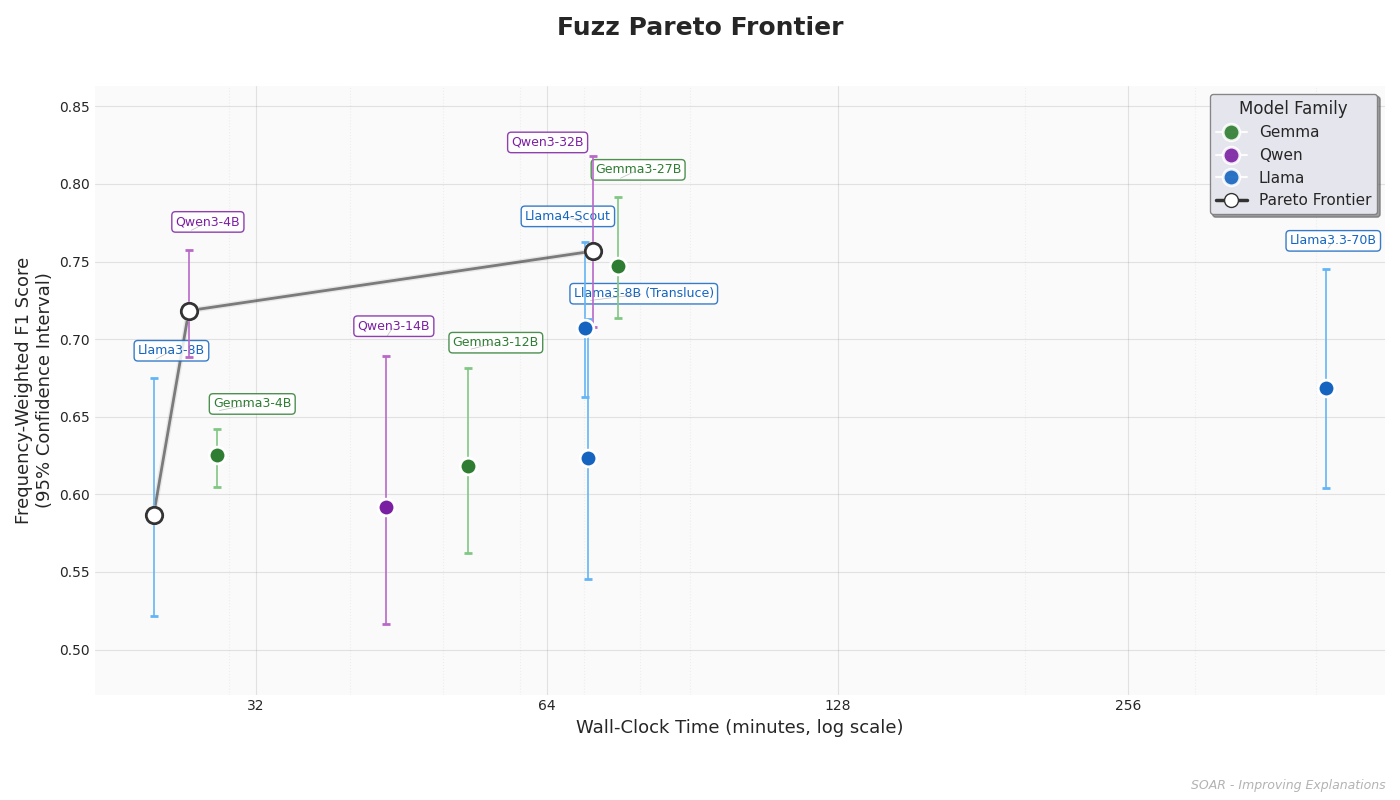

In [11]:
# Pareto plot for 'fuzz' - simplified wrapper
# Run this cell alone to get an interactive plot you can drag labels on and save.
fig_fuzz, dr_fuzz, pts_df_fuzz = plot_pareto('fuzz', save_on_init=True, show=True)
if fig_fuzz is None:
    print("Fuzz plot skipped or had no data.")

Created label 'Llama3-8B' at (25.069238475958507, 0.6717857469178765), picker=6
Created label 'Qwen3-4B' at (27.266449121634164, 0.6856362501992769), picker=6
Created label 'Gemma3-4B' at (29.130247934659323, 0.6029348957406301), picker=6
Created label 'Qwen3-14B' at (43.572769280274706, 0.6995412882528208), picker=6
Created label 'Gemma3-12B' at (53.10226345062256, 0.7025381330051953), picker=6
Created label 'Llama4-Scout' at (70.02310449282328, 0.6938341096977579), picker=6
Created label 'Llama3-8B (Transluce)' at (70.53215541442235, 0.6073275865457167), picker=6
Created label 'Qwen3-32B' at (71.41554892460505, 0.7216750677602186), picker=6
Created label 'Gemma3-27B' at (75.82396013736725, 0.7252066960042226), picker=6
Created label 'Llama3.3-70B' at (410.3826153000196, 0.6948411833082254), picker=6


Button(description='Save', layout=Layout(width='90px'), style=ButtonStyle())

Interactive mode: drag labels with the mouse; click the displayed 'Save' button to write the adjusted figure to the visualizations directory.
Saved enhanced pareto plot for detection: /home/jeremias/projects/delphi-explanations/results/visualizations/pareto_enhanced_detection.pdf
Saved enhanced pareto plot for detection: /home/jeremias/projects/delphi-explanations/results/visualizations/pareto_enhanced_detection.pdf


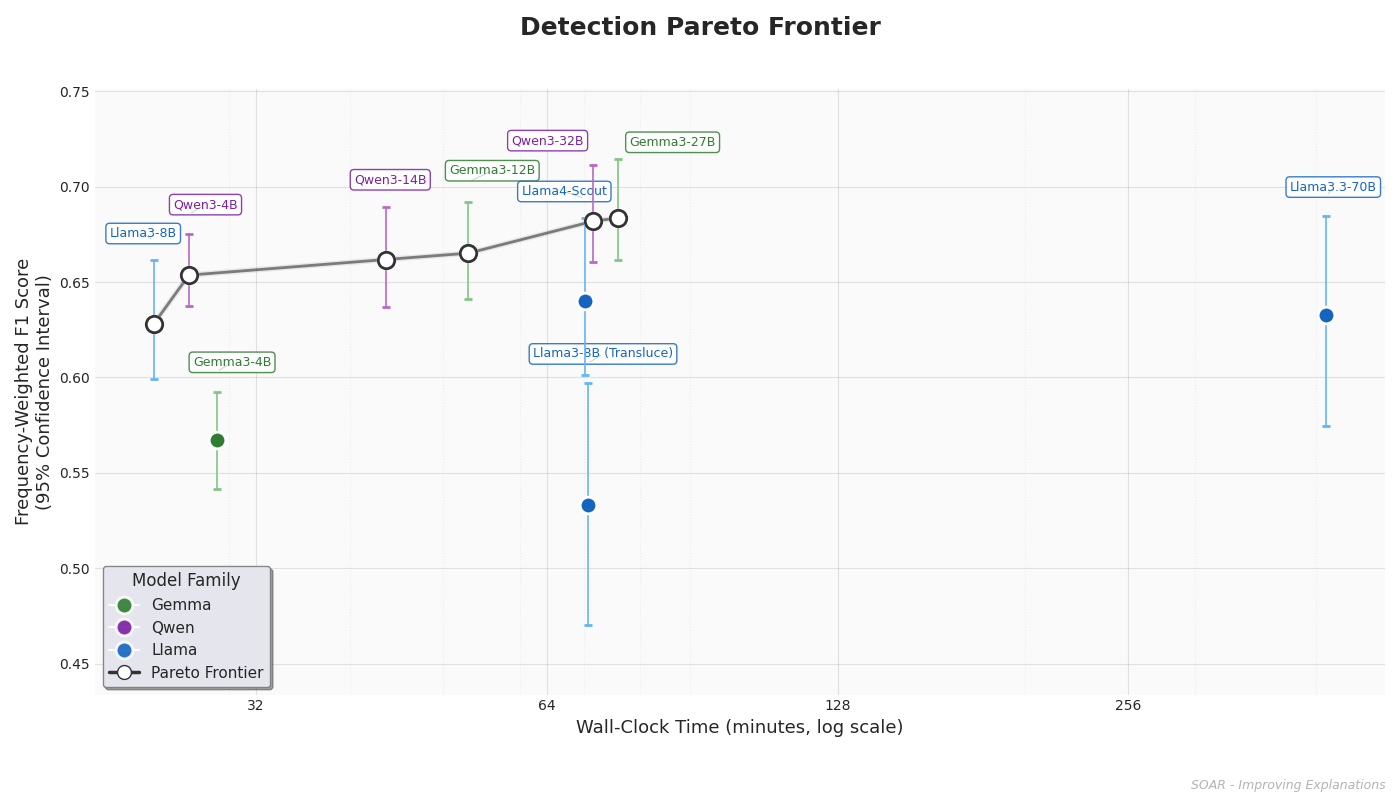

In [12]:
# Pareto plot for 'detection' - simplified wrapper
# Run this cell alone to get an interactive plot you can drag labels on and save.
fig_det, dr_det, pts_df_det = plot_pareto('detection', save_on_init=True, show=True)
if fig_det is None:
    print("Detection plot skipped or had no data.")